# 프로젝트 : 나랑 닮은 연예인을 찾아보자

[[E-05] Celebrity] 순서
1. 데이터 준비하기
2. 샘플 이미지를 불러온후 얼굴을face_recognition.face_locations 사용해 탐지하기
3. 얼굴 영역만 잘라서 뿌려줌
4. 얼굴 영역 가져오기
5. 얼굴 임베딩 만들기 FaceNet
6. 얼굴 임베딩 사이에서 거리측정
7. 두 임베딩 벡터 간의 거리를 계산하는 함수를 구현
8. 얼굴 임베딩 공간의 시각화
9. 가장 닮은꼴 얼굴 찾기

<평가기준>
1. TOP-5
2. 임베딩 거리 0.5 이내
3. matplotlib 등 다양한 시각화 도구를 하나 이상 이용

In [1]:
#모듈 불러오기

import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import face_recognition
%matplotlib inline    
from PIL import Image
import numpy as np

Step1. 사진 모으기 (얼굴 임베딩 만들기 FaceNet) 

file_list: ['이제훈.jpg', '윤동환.jpg', '오지호.jpg', '선우정아.jpg', '김아중.jpg', '태진아.jpg', '김호중.jpg', '송지효.jpg', '안소영.jpg', '김재화.jpg', '박용하.jpg', '한소희.jpg', '이상이.jpg', '윤홍빈.jpg', '고은미.jpg', '유주원.jpg', '송강호.jpg', '천이슬.jpg', '신주아.jpg', '우순실.jpg', '임형주.jpg', '박혜경.jpg', '서예화.jpg', '권태원.jpg', '김홍표.jpg', '송은영.jpg', '최용준.jpg', '조수민.jpg', '최윤영.jpg', '김필.jpg', '김환성.jpg', '문연주.jpg', '김현성.jpg', '마야.jpg', '김법래.jpg', '김영애.jpg', '조아영.jpg', '곽시양.jpg', 'MC몽.jpg', '이종원.jpg', '안효섭.jpg', '강경준.jpg', '최민수.jpg', '인쿠.jpg', '김광규.jpg', '김세정.jpg', '송영규.jpg', '최성원.jpg', '유서진.jpg', '서우진.jpg', '이일민.jpg', '김창숙.jpg', '주민준.jpg', '조유진.jpg', '정링컨.jpg', '김대명.jpg', '김정태.jpg', '안성기.jpg', '모세.jpg', '이승원.jpg', '김응수.jpg', '유니.jpg', '류덕환.jpg', '정재원.jpg', '랑연.jpg', '백도빈.jpg', '이승환.jpg', '송승헌.jpg', '이아현.jpg', '류현경.jpg', '정려원.jpg', '남주혁.jpg', '서지오.jpg', '이주영.jpg', '정동남.jpg', '백난아.jpg', '박신우.jpg', '한그루.jpg', '이원종.jpg', '견우.jpg', '메이린.jpg', '나인우.jpg', '유영석.jpg', '이나영.jpg', '이혜미.jpg', '김우빈.jpg', '백서빈.jpg', '정종준.jpg', '임지규.jpg', '서강준.jpg', '한영주

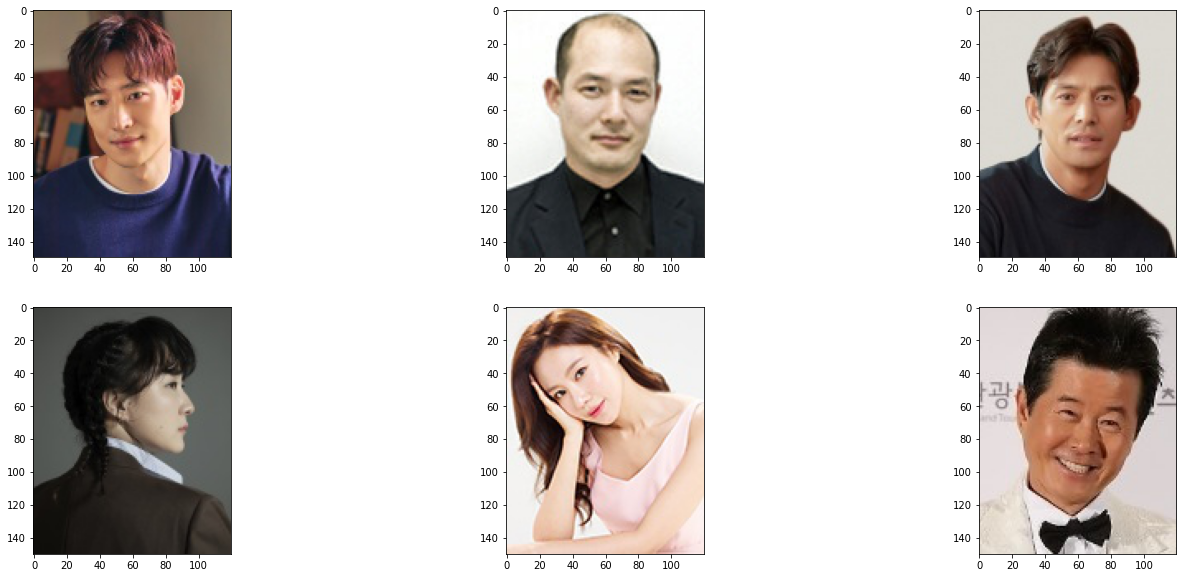

In [2]:
# 1) 파일리스트 만들기

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/data'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path+'/'+file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

Step2. 얼굴 영역 자르기 (get_cropped_face(image_file) 자르고 >PIL의 Image.fromarray를 통해서 PIL Image로 변환후 저장

In [3]:
# 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라주는 함수

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

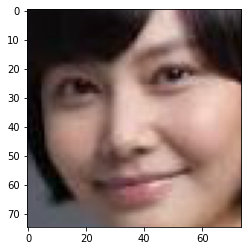

In [4]:
# 얼굴 영역이 정확히 잘리는 지 확인

image_path = os.getenv('HOME')+'/aiffel/face_embedding/data/추상미4.JPG'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

Step3. 얼굴 영역의 임베딩 추출하기

In [5]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수

def get_face_embedding(face):
    return face_recognition.face_encodings(face)

In [6]:
# 임베딩 구한후 dict 구조에 담아 리턴
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        image_path = os.path.join(dir_path, file)
        try:
            face = get_cropped_face(image_path)
            embedding = get_face_embedding(face)
            if len(embedding) > 0:
            # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담김.
                embedding_dict[os.path.splitext(file)[0]] = embedding[0]
                
        except:
            continue
        
    return embedding_dict

In [7]:
embedding_dict = get_face_embedding_dict(dir_path)

Step4. 모은 연예인들과 비교하기 (모은 연예인 사진들과 자신의 얼굴 사진에서 추출한 임베딩 벡터들 간의 거리를 비교, 가장 닮은 연예인)
get_nearest_face(name, top=5) 함수들을 응용

In [35]:
# 두 임베딩 벡터 간의 거리를 계산하는 함수를 구현

def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [36]:

# 본인 사진의 화장 전,후 거리를 확인해보자

print('내 사진끼리의 거리는?:', get_distance('psh', 'psh2'))

내 사진끼리의 거리는?: 0.4482835753745501


In [37]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [38]:
#입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리 정렬 및 출력
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    rank_cnt = 1 # 순위를 세는 변수
    pass_cnt = 1 # 건너뛴 숫자를 세는 변수(본인 사진 카운트)
    end = 0      # 닮은 꼴 5번 출력시 종료하기 위해 세는 변수
    for i in range(top+15):
        rank_cnt += 1
        if sorted_faces[i][0].find('psh') == 0:  # 본인 사진인 psh라는 파일명으로 시작하는 경우 제외합니다.
            pass_cnt += 1
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(rank_cnt - pass_cnt, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            end += 1
        if end == 5: # end가 5가 된 경우 연예인 5명 출력되었기에 종료합니다.
            break

In [39]:
#5 화장전 가장 닮은 사람은 누굴까요?
get_nearest_face('psh')

순위 1 : 이름(안소희), 거리(0.42319849053791897)
순위 2 : 이름(더원), 거리(0.42642947286974975)
순위 3 : 이름(하지은), 거리(0.4281634531581769)
순위 4 : 이름(남궁옥분), 거리(0.44427381573977626)
순위 5 : 이름(하시은), 거리(0.44984252996996976)


In [40]:
#5 화장후 가장 닮은 사람은 누굴까요?
get_nearest_face('psh2')

순위 1 : 이름(강수연), 거리(0.3924912909357128)
순위 2 : 이름(안은진), 거리(0.39666928572700383)
순위 3 : 이름(이유리), 거리(0.4106131326338597)
순위 4 : 이름(김새벽), 거리(0.4144588075410348)
순위 5 : 이름(유인나), 거리(0.41946146220987496)


Step5. 다양한 재미있는 시각화 시도해 보기

In [49]:
# 사진 경로 설정

mypicture1 = os.getenv('HOME')+'/aiffel/face_embedding/data/psh.jpg'
mypicture2 = os.getenv('HOME')+'/aiffel/face_embedding/data/psh2.JPG'

so = os.getenv('HOME')+'/aiffel/face_embedding/data/안소희.jpg'
jin = os.getenv('HOME')+'/aiffel/face_embedding/data/진희경.jpg'
ha = os.getenv('HOME')+'/aiffel/face_embedding/data/하지은.jpg'
su = os.getenv('HOME')+'/aiffel/face_embedding/data/강수연.jpg'
jin = os.getenv('HOME')+'/aiffel/face_embedding/data/안은진.jpg'
na = os.getenv('HOME')+'/aiffel/face_embedding/data/유인나.jpg'
kim = os.getenv('HOME')+'/aiffel/face_embedding/data/김새벽.jpg'
one = os.getenv('HOME')+'/aiffel/face_embedding/data/더원.jpg'

In [50]:
# 크롭한 얼굴을 저장해 보자

a1 = get_cropped_face(mypicture1)
a2 = get_cropped_face(mypicture2)

b1 = get_cropped_face(so)
b2 = get_cropped_face(jin)
b3 = get_cropped_face(ha)
b4 = get_cropped_face(su)
b5 = get_cropped_face(jin)
b6 = get_cropped_face(na)
b7 = get_cropped_face(kim)
b8 = get_cropped_face(one)

mypicture의 순위
순위 1 : 이름(안소희), 거리(0.36107689719729225)
순위 2 : 이름(안은진), 거리(0.36906292012955577)  
순위 3 : 이름(하지은), 거리(0.3703590842312735)  
순위 4 : 이름(강수연), 거리(0.3809516850126146)  
순위 5 : 이름(안은진), 거리(0.3886670633997685)


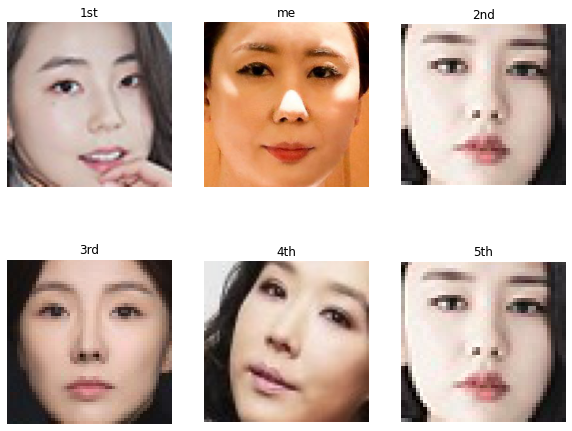

In [51]:
plt.figure(figsize=(10,8))

plt.subplot(231)
plt.imshow(b1)
plt.axis('off')
plt.title('1st')
plt.subplot(232)
plt.imshow(a2)
plt.axis('off')
plt.title('me')
plt.subplot(233)
plt.imshow(b2)
plt.axis('off')
plt.title('2nd')
plt.subplot(234)
plt.imshow(b3)
plt.axis('off')
plt.title('3rd')
plt.subplot(235)
plt.imshow(b4)
plt.axis('off')
plt.title('4th')
plt.subplot(236)
plt.imshow(b5)
plt.axis('off')
plt.title('5th')

print('''mypicture의 순위
순위 1 : 이름(안소희), 거리(0.36107689719729225)
순위 2 : 이름(안은진), 거리(0.36906292012955577)  
순위 3 : 이름(하지은), 거리(0.3703590842312735)  
순위 4 : 이름(강수연), 거리(0.3809516850126146)  
순위 5 : 이름(안은진), 거리(0.3886670633997685)''')

## 회고
1. embedding_dict = get_face_embedding_dict(dir_path)후 5분간 기다리기
  [*]가 실행중인걸 알지못하여 몇시간 새로고침만 OTL, 유현지님 도움으로 처리하였음 :)
   
2. 화장 전, 후 거리..0.44, 추천 순위가 바뀌는걸 보며..조용히 팩을 붙였다.미아네 ㅅㄹ

3. a1과 a2, b6~b8 데이터를 여러번 변경해 보았는데 2위 안은진.jpg 보다 
   비슷한 사진은 찾기가 어려웠는지 5th에 한번 더 반복하여 노출 되었다.